In [1]:
# !pip install gym-tetris  # Install gym-tetris if not already installed

import gym
import gym_tetris  # Import gym_tetris to register Tetris environments
from nes_py.wrappers import JoypadSpace
from gym_tetris.actions import SIMPLE_MOVEMENT

import numpy as np
import random
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
seed_value = 0
random.seed(seed_value)
np.random.seed(seed_value)

# Initialize the Tetris environment for baseline and training
env_random = gym_tetris.make('TetrisA-v3')  # Baseline (random policy) environment
env_random = JoypadSpace(env_random, SIMPLE_MOVEMENT)  # Restrict to simple movements
env_random.seed(42)  # Use a different seed for baseline environment

env = gym_tetris.make('TetrisA-v3')        # Q-learning training environment
env = JoypadSpace(env, SIMPLE_MOVEMENT)    # Restrict to simple movements
env.seed(seed_value)  # Seed the training environment for reproducibility

# Check action space
n_actions = env.action_space.n
print(f"Action space size: {n_actions} actions")


Action space size: 6 actions


In [11]:
def shaped_reward(prev, curr):
    dl = curr["number_of_lines"] - prev["number_of_lines"]   # +1 … +4
    dh = curr["board_height"]    - prev["board_height"]      # –ve or +ve
    ds = curr["score"]           - prev["score"]
    # reward weights:  +2  per cleared line
    #                  –0.02 per extra row
    return 2.0*dl - 0.02*dh + 0.01*ds

In [ ]:
# ────────────────────────────────────────────────────────────────
# Random-policy baseline — dense reward recorded episode-by-episode
# ────────────────────────────────────────────────────────────────
import gym, gym_tetris, random, numpy as np
from nes_py.wrappers import JoypadSpace
from gym_tetris.actions import SIMPLE_MOVEMENT

# 1️⃣  Re-create the random-baseline environment
env_random = JoypadSpace(gym_tetris.make("TetrisA-v3"), SIMPLE_MOVEMENT)
env_random.seed(42)


# 3️⃣  Baseline simulation
baseline_episodes = 200
max_steps         = 2000
DROP_ACTION       = 5              # hard-drop in SIMPLE_MOVEMENT
baseline_rewards  = []

for ep in range(1, baseline_episodes + 1):
    obs = env_random.reset()
    obs, _, done, info = env_random.step(0)        # prime `info`

    prev_info    = info
    total_reward = 0.0

    for step in range(max_steps):
        if done:
            break

        # hard-drop every other frame to lock pieces quickly
        action = DROP_ACTION if step % 2 == 0 else env_random.action_space.sample()
        obs, _, done, info = env_random.step(action)

        total_reward += shaped_reward(prev_info, info)
        prev_info     = info

    baseline_rewards.append(total_reward)
    print(f"Episode {ep:2d}/{baseline_episodes} → Reward = {total_reward:6.2f}")

# 4️⃣  Summary statistics
mean_R = np.mean(baseline_rewards)
std_R  = np.std(baseline_rewards)
print(f"\nRandom-policy baseline over {baseline_episodes} episodes:")
print(f" → Average Reward = {mean_R:.2f} (std = {std_R:.2f})")


c:\Users\Mark\Documents\School\ADS\autonomous_systems\opdracht 2\.venv\lib\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
c:\Users\Mark\Documents\School\ADS\autonomous_systems\opdracht 2\.venv\lib\site-packages\gym\utils\passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
c:\Users\Mark\Documents\School\ADS\autonomous_systems\opdracht 2\.venv\lib\site-packages\gym\utils\passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


Episode  1/200 → Reward =  -1.18
Episode  2/200 → Reward =  -0.77
Episode  3/200 → Reward =  -0.87
Episode  4/200 → Reward =  -1.96
Episode  5/200 → Reward =  -1.38
Episode  6/200 → Reward =  -0.98
Episode  7/200 → Reward =  -1.19
Episode  8/200 → Reward =  -1.67
Episode  9/200 → Reward =  -1.53
Episode 10/200 → Reward =  -1.06
Episode 11/200 → Reward =  -0.88
Episode 12/200 → Reward =  -1.28
Episode 13/200 → Reward =  -1.09
Episode 14/200 → Reward =  -1.98
Episode 15/200 → Reward =  -0.78
Episode 16/200 → Reward =  -1.19
Episode 17/200 → Reward =  -0.78
Episode 18/200 → Reward =  -1.59
Episode 19/200 → Reward =  -1.00
Episode 20/200 → Reward =  -0.88
Episode 21/200 → Reward =  -0.69
Episode 22/200 → Reward =  -1.18
Episode 23/200 → Reward =  -0.87
Episode 24/200 → Reward =  -0.78
Episode 25/200 → Reward =  -1.27
Episode 26/200 → Reward =  -1.98
Episode 27/200 → Reward =  -1.07
Episode 28/200 → Reward =  -1.28
Episode 29/200 → Reward =  -1.17
Episode 30/200 → Reward =  -1.87
Episode 31

In [12]:
# Define the discrete state representation mapping for the Q-table
piece_to_index = {'I': 0, 'J': 1, 'L': 2, 'O': 3, 'S': 4, 'T': 5, 'Z': 6}

# Initialize Q-table dimensions [piece_type x board_height x actions]
n_piece_types = len(piece_to_index)
n_height_levels = 21  # possible board heights 0 through 20
Q_table = np.zeros((n_piece_types, n_height_levels, n_actions))

# Hyperparameters for Q-learning
alpha = 0.1    # learning rate
gamma = 0.99   # discount factor
epsilon = 1.0  # starting exploration rate (100% explore at start)
epsilon_min = 0.1   # minimum exploration rate
epsilon_decay = 0.97  # decay factor per episode (will roughly reach 0.1 by ~100 episodes)

# Function to get our simplified state (piece_index, board_height) from info
def get_state_from_info(info):
    """Extract the simplified state (piece_type, board_height) from the info dict."""
    piece_type = info.get('current_piece', None)
    height = info.get('board_height', None)
    if piece_type is None or height is None:
        # In case info is not available, return a default state (this shouldn't normally happen after the first step)
        return None
    # Map piece type to index for Q-table
    piece_idx = piece_to_index.get(piece_type, None)
    return (piece_idx, height)


In [13]:
# ────────────────────────────────────────────────────────────────
# Q-learning with dense reward  +  fast soft-drop every frame
# ────────────────────────────────────────────────────────────────
import gym, gym_tetris, random, numpy as np
from nes_py.wrappers import JoypadSpace
from gym_tetris.actions import SIMPLE_MOVEMENT

# 1️⃣  Environment
env = JoypadSpace(gym_tetris.make("TetrisA-v3"), SIMPLE_MOVEMENT)
env.seed(0)

# SIMPLE_MOVEMENT indexing: 0 noop · 1← · 2→ · 3↓ · 4 A(rotate) · 5?
DOWN_ACTION = 3                     # constant soft-drop each step
n_actions   = env.action_space.n

# 2️⃣  State encoding  (piece type, board height)
# ────────────────────────────────────────────────────────────────
# Robust state encoder (handles 'Ld', 'Id', 'Td', …)
# ────────────────────────────────────────────────────────────────
piece_to_idx = {'I':0,'J':1,'L':2,'O':3,'S':4,'T':5,'Z':6}
n_piece, n_h = 7, 21                         # 0–20 rows high

def get_state(info):
    piece_letter = info["current_piece"][0]
    height_total = min(info["board_height"], n_h-1)
    well_height  = info["well_column"]          # 0–20, already in info dict
    well_disc    = min(well_height // 4, 5)     # bucket into 6 bins
    piece_idx    = piece_to_idx[piece_letter]
    return piece_idx, height_total, well_disc    # new 3-dim state


# 4️⃣  Q-table + hyper-parameters
Q              = np.zeros((n_piece, n_h, n_actions), dtype=np.float32)
α, γ           = 0.25, 0.99
ε, ε_min       = 1.0, 0.05
ε_decay        = 0.99

episodes       = 200
max_steps      = 2_000
training_rew   = []

for ep in range(1, episodes+1):
    print(f"Episode {ep}/{episodes}...")
    obs = env.reset()
    obs, _, done, info = env.step(0)          # prime `info`
    prev_info          = info
    state              = get_state(info)
    G                  = 0.0                  # episodic dense return

    for t in range(max_steps):
        if done:
            break

        # ε-greedy selection
        if random.random() < ε:
            a = env.action_space.sample()
        else:
            a = int(np.argmax(Q[state[0], state[1]]))

        # ── NEW: alternate decision / soft-drop ─────────────────────
        action = a if t % 2 == 0 else DOWN_ACTION
        # ────────────────────────────────────────────────────────────

        obs, _, done, info = env.step(action)
        r = shaped_reward(prev_info, info)

        G += r

        # Q-update
        next_state = get_state(info) if not done else None
        best_next  = 0.0 if next_state is None else np.max(Q[next_state[0], next_state[1]])
        Q[state[0], state[1], a] += α * (r + γ*best_next - Q[state[0], state[1], a])

        state, prev_info = (next_state if next_state is not None else state), info

    training_rew.append(G)
    ε = max(ε_min, ε*ε_decay)

    if ep % 20 == 0:
        print(f"Ep {ep:3d} | ε={ε:.3f} | mean last 20 R = {np.mean(training_rew[-20:]):6.2f}")

env.close()


Episode 1/200...


KeyError: 'well_column'

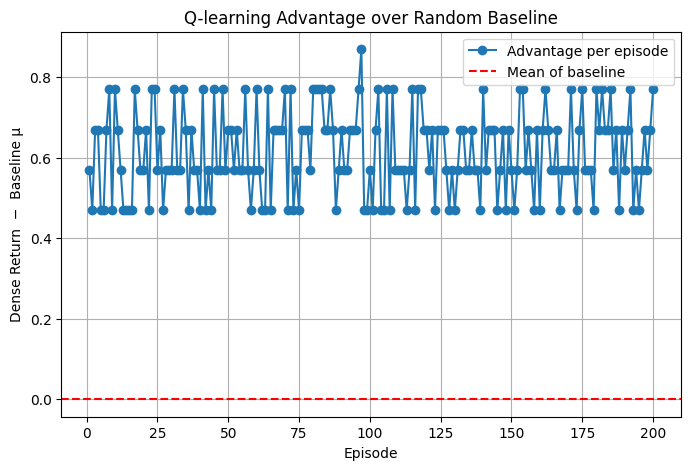

In [8]:
# ────────────────────────────────────────────────────────────────
# Plot advantage (Q-learning – baseline mean) per episode
# ────────────────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt

train_returns   = np.array(training_rew)      # Q-learning dense returns
baseline_mean   = np.mean(baseline_rewards)   # scalar
advantage       = train_returns - baseline_mean
episodes        = np.arange(1, len(advantage) + 1)

plt.figure(figsize=(8, 5))
plt.plot(episodes, advantage, marker='o', linestyle='-', label='Advantage per episode')

plt.axhline(0, color='red', linestyle='--', label='Mean of baseline')
plt.title("Q-learning Advantage over Random Baseline")
plt.xlabel("Episode")
plt.ylabel("Dense Return  −  Baseline µ")
plt.legend()
plt.grid(True)
plt.show()


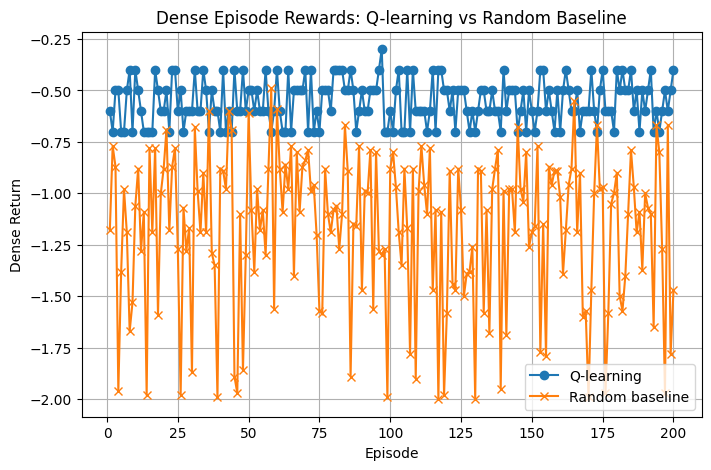

In [10]:
# ────────────────────────────────────────────────────────────────
# Plot dense episode returns: Q-learning vs Random baseline
# ────────────────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣  Ensure arrays
q_returns   = np.array(training_rew)      # Q-learning dense returns
b_returns   = np.array(baseline_rewards)  # random-policy dense returns

# 2️⃣  Episode indices
ep_q = np.arange(1, len(q_returns) + 1)
ep_b = np.arange(1, len(b_returns) + 1)

# 3️⃣  Plot
plt.figure(figsize=(8, 5))
plt.plot(ep_q, q_returns, marker='o', linestyle='-', label='Q-learning')
plt.plot(ep_b, b_returns, marker='x', linestyle='-', label='Random baseline')

plt.title("Dense Episode Rewards: Q-learning vs Random Baseline")
plt.xlabel("Episode")
plt.ylabel("Dense Return")
plt.legend()
plt.grid(True)
plt.show()
